elapsed time for fitting is
95.04518151283264


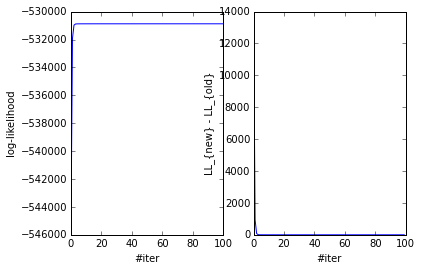

In [30]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting
import ssm_scripts

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

%matplotlib inline


""" Set problem size """

yDim = 90
xDim = 6
uDim = 0

T = 5000
Trial = 1


""" Generate some sensible parameters that give a learnable problem """

#trueParameters = {}
#while True:
#    W    = np.random.normal(size=[xDim,xDim])
#    if np.abs(np.linalg.det(W)) > 0.001:
#        break
#trueParameters['A'] = np.dot(W,np.dot(np.diag(np.linspace(0.15,0.3,xDim)), sp.linalg.inv(W)))


#trueParameters['A'] = npzfile['arr_2'].copy()
#trueParameters['B'] = npzfile['arr_3'].copy()
#trueParameters['Q'] = npzfile['arr_4'].copy()
#trueParameters['mu0'] = npzfile['arr_5'].copy()
#trueParameters['V0'] = npzfile['arr_6'].copy()
#trueParameters['C'] = npzfile['arr_7'].copy()
#trueParameters['d'] = npzfile['arr_8'].copy()
#trueParameters['R'] = npzfile['arr_9'].copy()
#initParameters = [None,None,None,None,None,None,None,None]
#initParameters[0] = npzfile['arr_10'].copy()
#initParameters[1] = npzfile['arr_11'].copy()
#initParameters[2] = npzfile['arr_12'].copy()
#initParameters[3] = npzfile['arr_13'].copy()
#initParameters[4] = npzfile['arr_14'].copy()
#initParameters[5] = npzfile['arr_15'].copy()
#initParameters[6] = npzfile['arr_16'].copy()
#initParameters[7] = npzfile['arr_17'].copy()
#del npzfile
#yIn = yIn[:,range(T),:]
#xIn = xIn[:,range(T),:]

""" Set observation protocol """

# mixing global and dense:
subpops = [[], list(range(0,yDim)), list(range(45,yDim)), list(range(0,45))]
obsPops = [1]
obsTime = [1]
tempStitchOrder = 3
for t in range(1,int(T/3)+1):
    if np.mod(t,tempStitchOrder)==0:
        obsPops.append(0)
        obsTime.append(t)
        obsPops.append(1)
        obsTime.append(t+1)
while obsTime[-1] >= int(T/3):
    obsTime.pop()
    obsPops.pop()
obsTime[-1] = int(T/3)

obsTime.append(int(2*T/3))
obsPops.append(2)
obsTime.append(int(T))
obsPops.append(3)

"""

subpops = [list(range(0,yDim)),list(range(0,yDim))]
obsPops = [0,1]
obsTime = [int(T/2),T]




# observing global and sparsely:    
subpops = [[], list(range(0,yDim))]
obsPops = []
obsTime = []

tempStitchOrder = 2
obsPops = [1]
obsTime = [1] # population observed at t = 0
i = 1;
t = 0
while t < T:
    t = int(tempStitchOrder * i)
    obsPops.append(0)   # observe empty subpop
    obsTime.append(t)   # until round(i*tempStitchOrder)
    obsPops.append(1)   # then observe full subpop
    obsTime.append(t+1) # for 1 more time step
    
    i += 1
# ended while loop because last entry was >= T !    
while obsTime[-1] > T:
    obsTime.pop()
    obsPops.pop()
obsTime[-1] = T

"""
    
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}

fitOptions = {'ifUseB' : False,  
              'maxIter': 100, 
              'ifPlotProgress' : True,
              'covConvEps' : 1e-30,
              'ifTraceParamHist': False,
              'ifInitCwithPCA' : True
             }

""" Fit the model, save results """

sf = '/home/mackelab/Desktop/Projects/Stitching/results/test_problemsLDS_save_tempStitching_mixed'
[yOut,xOut,u,learnedPars,initPars,truePars] = ssm_scripts.run(xDim, yDim, uDim, T, 
                                                              obsScheme, fitOptions,
                                                              y = yOut, x = xOut,
                                                              truePars=trueParameters,
                                                              initPars=initParameters,
                                                              saveFile=sf)



In [31]:
truePars = trueParameters

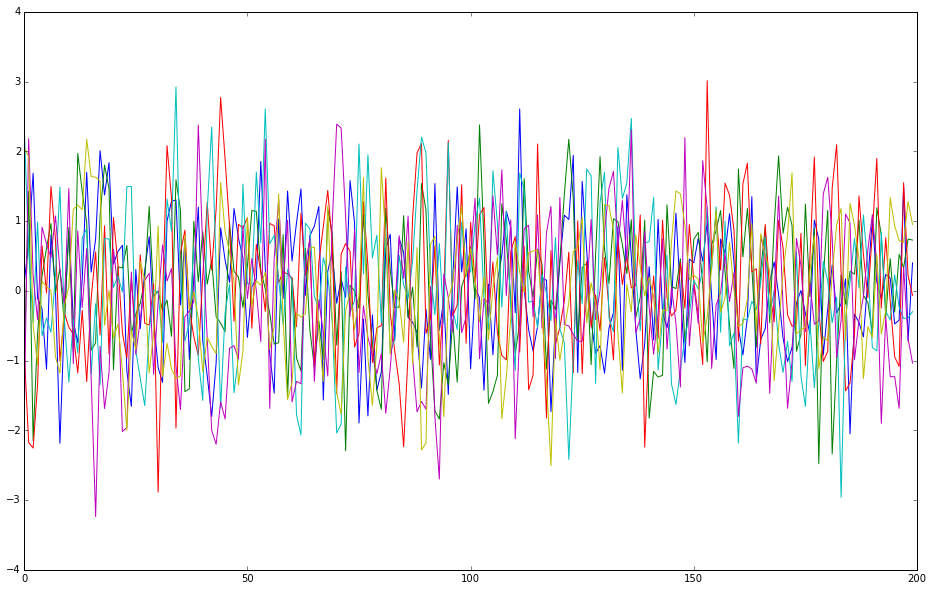

In [32]:
plt.figure(figsize=(16,10))
plt.plot(xOut[:,range(0, int(T/25)),0].transpose())


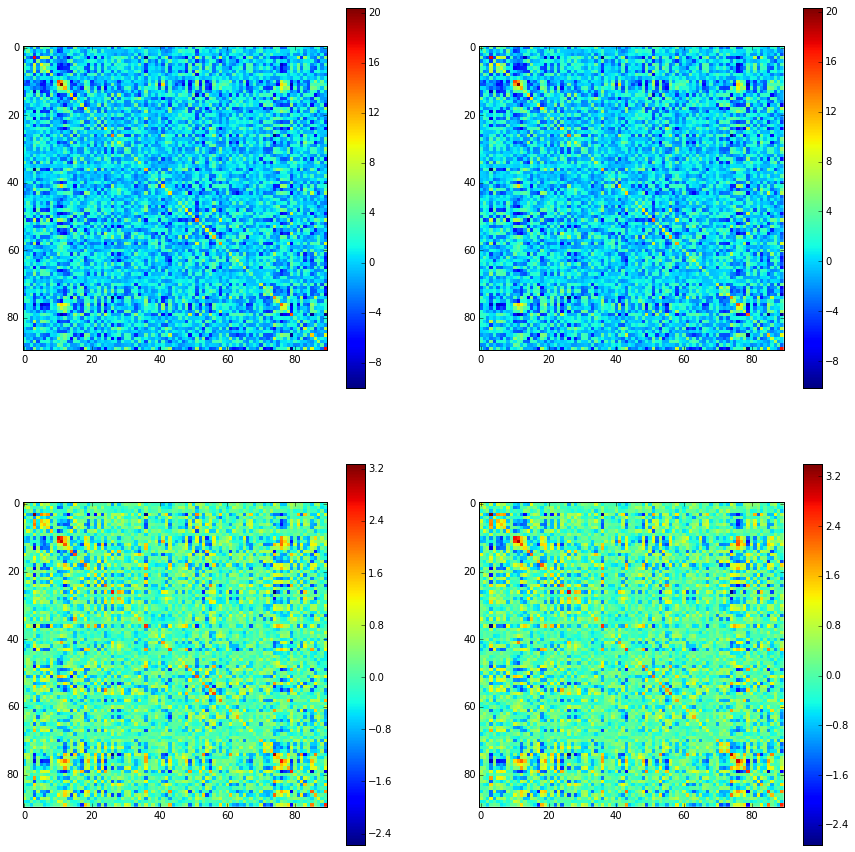

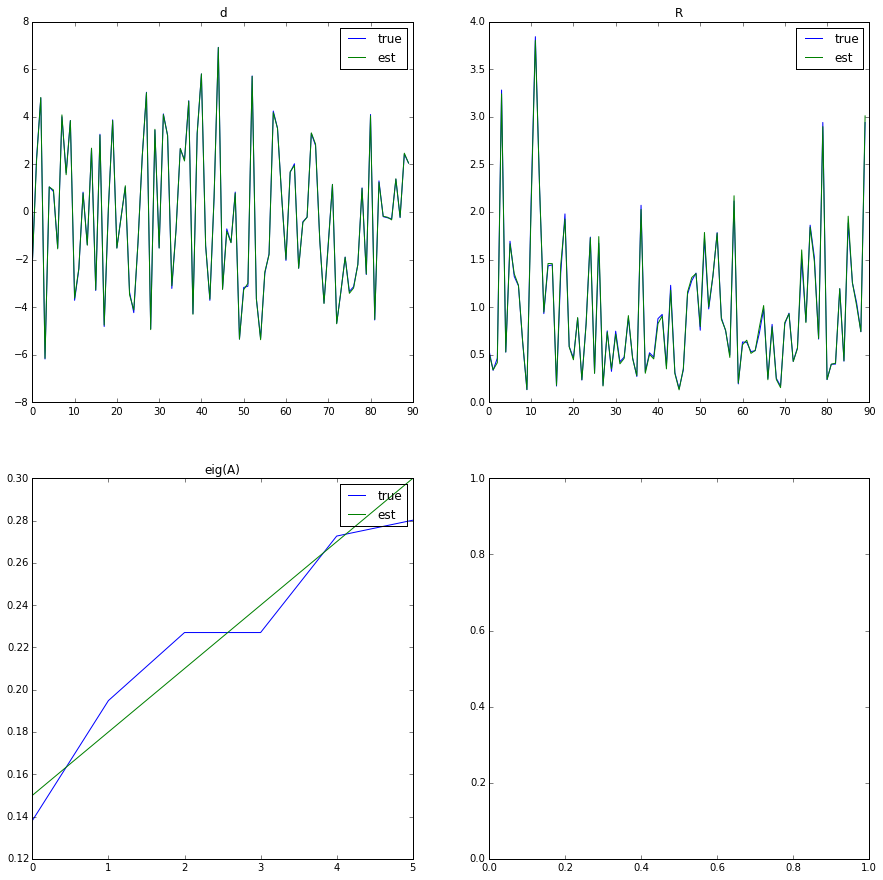

In [33]:
[A,B,Q,mu0,V0,C,d,R] = learnedPars 
Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]

plt.figure(1,figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(np.dot(np.dot(C, Pi), C.transpose()) + np.diag(R), interpolation='none')
plt.colorbar()
plt.subplot(2,2,2)
Pi_true = np.array([sp.linalg.solve_discrete_lyapunov(truePars[0], truePars[2])])[0,:,:]
plt.imshow(np.dot(np.dot(truePars[5],Pi_true),truePars[5].transpose()) +
           truePars[7],
           interpolation='none')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.dot(np.dot(np.dot(C, A), Pi), C.transpose()), interpolation='none' )
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.dot(np.dot(np.dot(truePars[5], truePars[0]), Pi_true), 
                                truePars[5].transpose()), 
          interpolation='none' )
plt.colorbar()

plt.figure(2,figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(d)
plt.plot(truePars[6])
plt.legend(['true', 'est'])
plt.title('d')
plt.subplot(2,2,2)
plt.plot(R)
plt.plot(np.diag(truePars[7]))
plt.legend(['true', 'est'])
plt.title('R')
plt.subplot(2,2,3)
plt.plot(np.sort(np.linalg.eig(A)[0]))
plt.plot(np.sort(np.linalg.eig(truePars[0])[0]))
plt.legend(['true', 'est'])
plt.title('eig(A)')
plt.subplot(2,2,4)


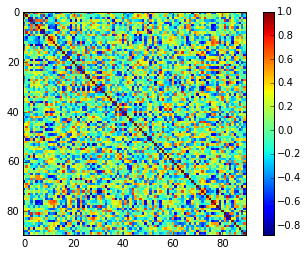

In [34]:
corry = np.corrcoef(yOut[:,:,0])
corry.shape
%matplotlib inline
plt.imshow(corry, interpolation='none')
plt.colorbar()

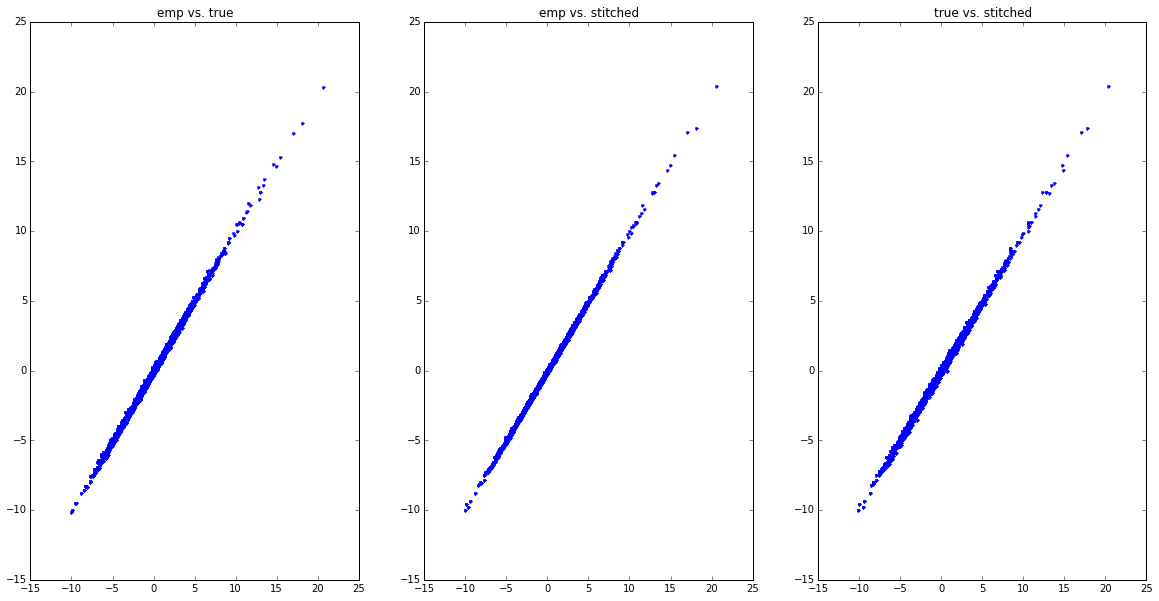

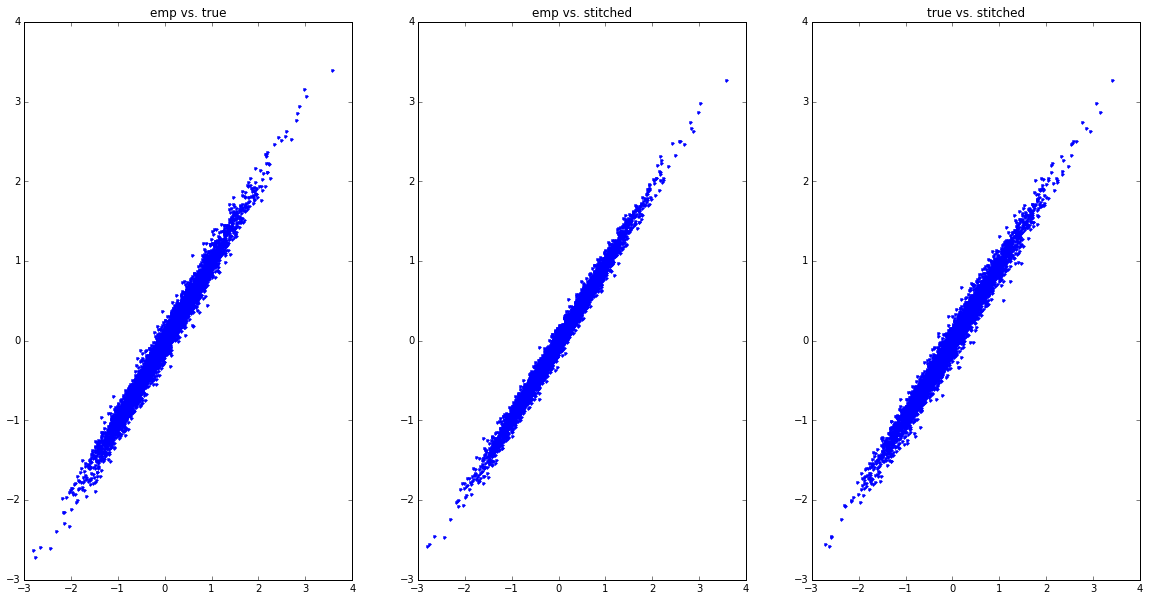

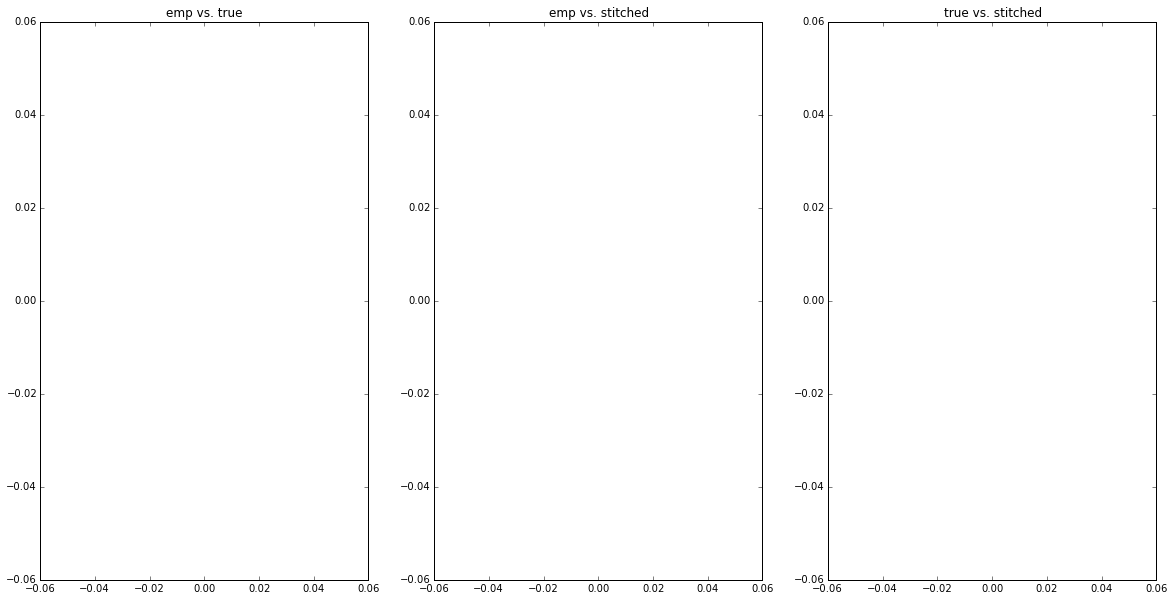

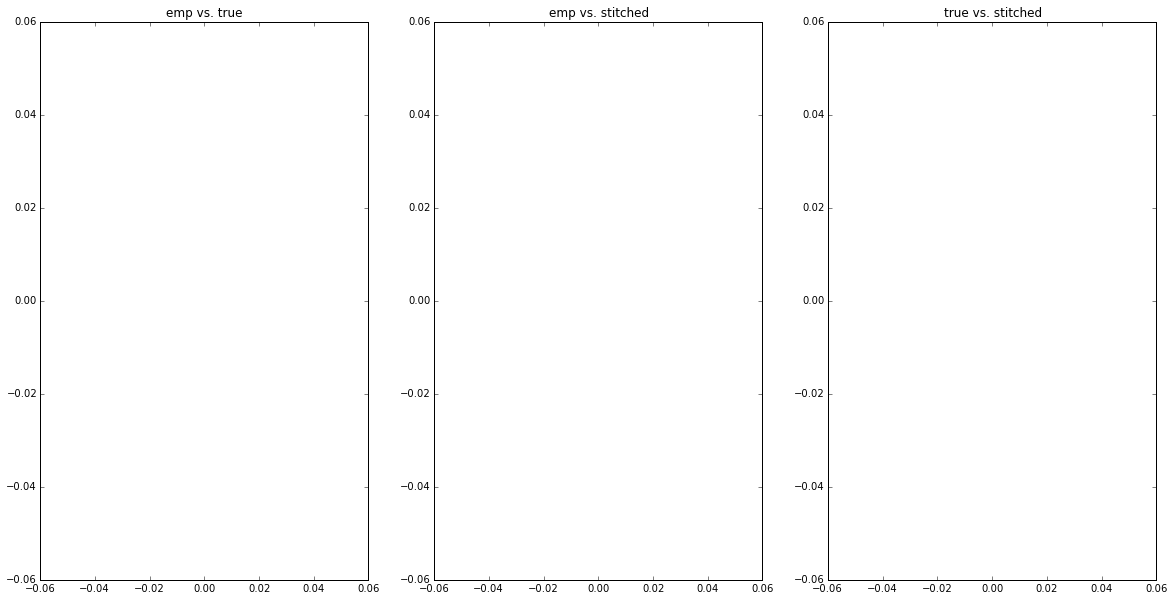

In [35]:
covy_h= np.dot(np.dot(C, Pi), C.transpose()) + np.diag(R)
covy_t= np.dot(np.dot(truePars[5],Pi_true),truePars[5].transpose()) + truePars[7]

y_tl = np.zeros([2*yDim,T-1])
y_tl[range(yDim),:] = yOut[:,range(0,T-1),0]
y_tl[range(yDim,2*yDim),:] = yOut[:,range(1,T),0]
covy = np.cov(y_tl)

covy_e=    covy[np.ix_(range(yDim),range(yDim))]
covy_tl_e= covy[np.ix_(range(yDim,2*yDim),range(0,yDim))]

covy_tl_h= np.dot(np.dot(C, np.dot(A,Pi)), C.transpose())
covy_tl_t=(np.dot(np.dot(truePars[5],np.dot(truePars[0], Pi_true)),truePars[5].transpose()))
%matplotlib inline
idxStitched = np.ones([yDim,yDim],dtype = bool)
for i in range(len(obsScheme['subpops'])):
    if len(obsScheme['subpops'][i])>0:
        idxStitched[np.ix_(obsScheme['subpops'][i],obsScheme['subpops'][i])] = False
plt.imshow(idxStitched,interpolation='none')

%matplotlib inline
plt.figure(1, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_e[np.invert(idxStitched)], covy_t[np.invert(idxStitched)], '.')
plt.title('emp vs. true')
plt.subplot(1,3,2)
plt.plot(covy_e[np.invert(idxStitched)], covy_h[np.invert(idxStitched)], '.')
plt.title('emp vs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_t[np.invert(idxStitched)], covy_h[np.invert(idxStitched)], '.')
plt.title('true vs. stitched')

plt.figure(2, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_tl_e[np.invert(idxStitched)], covy_tl_t[np.invert(idxStitched)], '.')
plt.title('emp vs. true')
plt.subplot(1,3,2)
plt.plot(covy_tl_e[np.invert(idxStitched)], covy_tl_h[np.invert(idxStitched)], '.')
plt.title('emp vs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_tl_t[np.invert(idxStitched)], covy_tl_h[np.invert(idxStitched)], '.')
plt.title('true vs. stitched')

plt.figure(3, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_e[idxStitched], covy_t[idxStitched], '.')
plt.title('emp vs. true')
plt.subplot(1,3,2)
plt.plot(covy_e[idxStitched], covy_h[idxStitched], '.')
plt.title('emp vs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_t[idxStitched], covy_h[idxStitched], '.')
plt.title('true vs. stitched')

plt.figure(4, figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(covy_tl_e[idxStitched], covy_tl_t[idxStitched], '.')
plt.title('emp vs. true')
plt.subplot(1,3,2)
plt.plot(covy_tl_e[idxStitched], covy_tl_h[idxStitched], '.')
plt.title('emp vs. stitched')
plt.subplot(1,3,3)
plt.plot(covy_tl_t[idxStitched], covy_tl_h[idxStitched], '.')
plt.title('true vs. stitched')

In [12]:
truePars

[array([[ 0.2288313 , -0.00141712, -0.01334891, -0.02576969, -0.02114361,
          0.01397818],
        [ 0.01849455,  0.1859579 , -0.01392052, -0.06626684, -0.01984785,
         -0.01517918],
        [ 0.02076796, -0.04841887,  0.2499681 , -0.02888103, -0.02508607,
         -0.04689887],
        [-0.02352755, -0.0060492 ,  0.00076454,  0.26555841,  0.01484706,
          0.00200576],
        [-0.03602904, -0.00240046,  0.00262998,  0.03514959,  0.24719906,
          0.00123444],
        [ 0.00792352,  0.01303556, -0.0390837 ,  0.00226701, -0.02055084,
          0.17248523]]),
 array([], shape=(6, 0), dtype=float64),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]]),
 array([ 0.06022081, -2.03820031, -0.19905397,  1.1483172 , -0.61208863,
         1.09692119]),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.

In [13]:
initPars

[array([[ 0.60623904,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.81613902,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.13845094,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.48912854,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.19489823,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.22068904]]),
 array([], shape=(6, 0), dtype=float64),
 array([[ 3.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  3.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  3.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.]]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.]),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,

In [14]:
trueParameters = truePars.copy()
initParameters = initPars.copy()

In [7]:
#sfs = '/home/marcel/Desktop/Projects/Stitching/results/test_runs/LDS_setup_test'
#npzloadfile = np.load(sf+'_tmp_'+str(41)+'.npz')
#npzloadfile['arr_2']

array([[  5.50749899e-01,   6.21232002e-02,   3.12364327e-02,
         -3.32067298e-02,  -1.16858545e-02,   2.55868235e-02,
          1.34068021e-02,   6.79250392e-02,   4.23456909e-03,
          3.56323272e-02],
       [  3.98644631e-02,   7.61127790e-01,  -7.90067044e-02,
         -3.18583566e-02,  -2.54275809e-02,  -1.03823612e-01,
          6.32736829e-03,   5.10687347e-02,   4.38683138e-03,
          2.59130197e-02],
       [  2.80684223e-02,  -7.85257051e-02,   4.46354902e-01,
          1.39779162e-02,  -4.58212068e-02,   1.58524896e-02,
          4.92036036e-03,   1.68693522e-02,  -4.80054792e-03,
          2.38374621e-02],
       [ -1.62923999e-02,  -1.84139104e-02,   1.87833589e-03,
          3.56451968e-01,   3.61715015e-02,   7.63858119e-03,
         -2.41353236e-02,   2.91024838e-02,  -2.22470794e-02,
          2.04243087e-02],
       [  3.30635623e-04,   1.12885731e-02,  -2.89510582e-02,
         -3.25375859e-02,   8.42992180e-01,  -8.67301054e-02,
         -1.10056190e-02